In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import parallel_backend
from joblib import Parallel, delayed

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- 1. Load Data ---
df = pd.read_csv("sentimentdataset.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df["Date"] = df["Timestamp"].dt.date

# Group by user and date
user_daily_activity = df.groupby(["User", "Date"]).agg(
    total_posts=("Text", "count"),  
    total_likes=("Likes", "sum"),
    total_retweets=("Retweets", "sum"),
    first_post=("Timestamp", "min"),  
    last_post=("Timestamp", "max")
).reset_index()

user_daily_activity["Active_Hours"] = (user_daily_activity["last_post"] - user_daily_activity["first_post"]).dt.total_seconds() / 3600
user_daily_activity["Active_Hours"].fillna(0, inplace=True)
user_daily_activity["Daily_Usage_Time"] = user_daily_activity["total_posts"] * 15 / 60
user_daily_activity["Total_Interactions"] = user_daily_activity["total_likes"] + user_daily_activity["total_retweets"]

# Define addiction label
user_daily_activity["Addicted"] = ((user_daily_activity["Daily_Usage_Time"] > 2) | 
                                   (user_daily_activity["Total_Interactions"] > 100)).astype(int)

# Merge back
df = df.merge(user_daily_activity[["User", "Date", "Addicted"]], on=["User", "Date"], how="left")
df.dropna(inplace=True)

# --- 2. Encode Sentiment to Numeric ---
df["sentiment_num"] = pd.factorize(df["Sentiment"])[0]

# --- 3. Prepare features and target ---
X = df[["sentiment_num", "Likes", "Retweets"]]
y = df["Addicted"]

# --- 4. Parallel Scaling (using Joblib for multi-core CPU usage) ---
scaler = StandardScaler()
with parallel_backend('threading', n_jobs=-1):
    X_scaled = scaler.fit_transform(X)

# --- 5. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42)

# --- 6. Define Neural Network Model ---
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# --- 7. Train with early stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# --- 8. Evaluate ---
y_pred = (model.predict(X_test) > 0.5).astype(int)

print("\nNeural Network Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


/var/folders/rv/q52q8kmj0s558xpyhlshtzw00000gn/T/ipykernel_6009/1038524861.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  user_daily_activity["Active_Hours"].fillna(0, inplace=True)
/Users/kellyg/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)
/Users/kellyg/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7534 - loss: 0.6178 - val_accuracy: 0.8265 - val_loss: 0.5791
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8238 - loss: 0.5542 - val_accuracy: 0.8265 - val_loss: 0.5269
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8855 - loss: 0.4819 - val_accuracy: 0.8265 - val_loss: 0.4813
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8435 - loss: 0.4842 - val_accuracy: 0.8265 - val_loss: 0.4356
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8606 - loss: 0.4425 - val_accuracy: 0.8265 - val_loss: 0.3960
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8687 - loss: 0.3800 - val_accuracy: 0.8265 - val_loss: 0.3612
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8642 - loss: 0.3758 - val_accuracy: 0.8265 - val_loss: 0.3325
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8592 - loss: 0.3476 - val_accuracy: 0.8265 - val_loss: 0.3136
Epoch 9

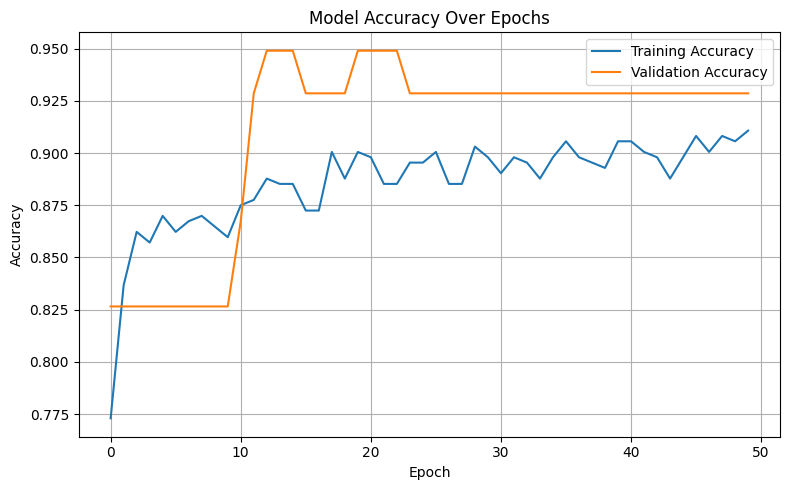

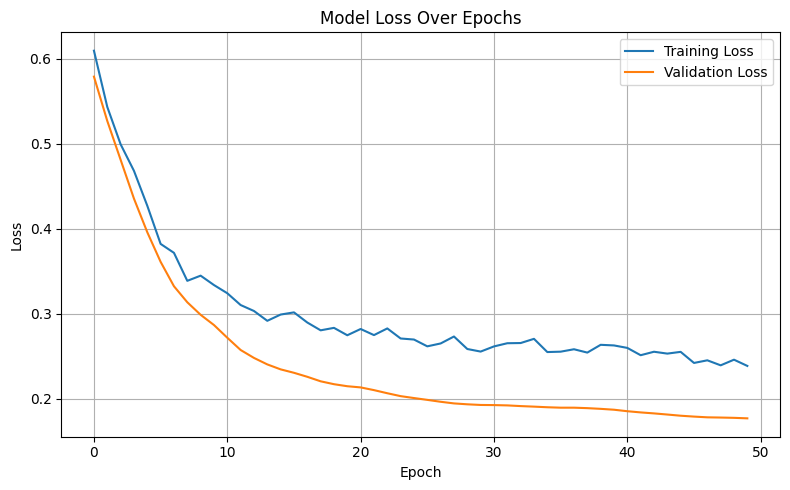

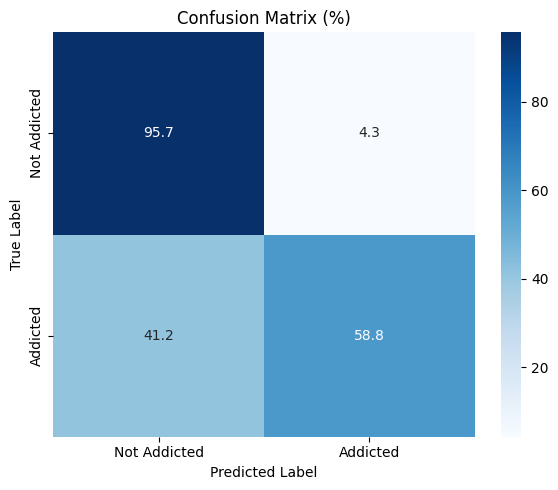

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


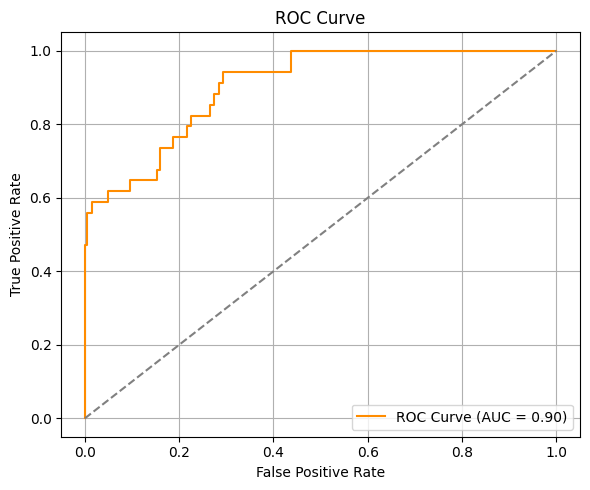

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# --- 1. Accuracy Over Epochs ---
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 2. Loss Over Epochs ---
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 3. Confusion Matrix (as percentages) ---
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=['Not Addicted', 'Addicted'],
            yticklabels=['Not Addicted', 'Addicted'])
plt.title('Confusion Matrix (%)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# --- 4. ROC Curve ---
y_proba = model.predict(X_test).ravel()  # get raw probabilities
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
